<a href="https://colab.research.google.com/github/Francesca-Rossi/ITA_university_advisor/blob/main/IAuniversity_datset_completo_backup_20_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importazione librerie

In [110]:
import gspread 
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import plot_confusion_matrix
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from collections import Counter
from numpy import where
from numpy import mean
from numpy import std
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
import os
from oauth2client.service_account import ServiceAccountCredentials
from google.colab import drive
from nltk.corpus import stopwords
from nltk.stem.snowball import ItalianStemmer
import json as js
import seaborn as sns; 


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#Funzioni principali

In [111]:
stop_ita = stopwords.words('italian')
stop_en = stopwords.words('english')
stemmer = ItalianStemmer()


#CLEANING DATA
def lang_stop_words(feature, lang):
  if (lang == "IT"):
    feature=feature.apply(lambda x: [item for item in x if item not in stop_ita]) 
  elif (lang == "EN"):
    feature=feature.apply(lambda x: [item for item in x if item not in stop_en]) 
  else:
    feature=feature.apply(lambda x: [item for item in x if item not in stop_ita])
    feature=feature.apply(lambda x: [item for item in x if item not in stop_en])
  return feature

def data_cleaning(feature, regex_list):
  feature=feature.apply(lambda x: x.lower()) #minuscolo
  feature=feature.str.strip() #eliminaz spazi bianchi inizio e fine
  for regex in regex_list:
    feature=feature.str.replace(regex, ' ')
    #feature=feature.str.replace(r'\s\s+', ' ') #eliminaz doppi spazi
  for char in string.punctuation:
    feature=feature.str.replace(char, ' ')
  return feature

#PREPROCESSING TEXT
def preprocessing_text(dataframe, feature, key, lang): 
  feature=feature.str.strip() #elimino spazi bianchi a inizio e fine
  feature =dataframe.apply(lambda row: nltk.word_tokenize(row[key]), axis=1)
  feature =lang_stop_words(feature, lang)
  feature=feature.apply(lambda x: [stemmer.stem(y) for y in x]) # Stem every word
  feature=feature.apply(' '.join)
  return feature

#FEATURE ENGINEERING TEXT 
def tf_vector(vectorize, feature):
  tf_matrix = vectorize.fit_transform(feature)
  tf_matrix = tf_matrix.toarray()
  vocab = vectorize.get_feature_names()
  return pd.DataFrame(np.round(tf_matrix, 2), columns=vocab)

def bag_of_words(vectorize,feature):
  vectorize.fit(feature)
  bag_array= vectorize.transform(feature).toarray()
  vocab = vectorize.get_feature_names()
  return pd.DataFrame(bag_array, columns=vocab)

#FEATURE ENGINEERING CATEGORICAL DATA
encoder = LabelEncoder()
def one_hot_encoding(feature, key):
  genre_labels = encoder.fit_transform(feature) 
  genre_mappings = {index: label for index, label in enumerate(encoder.classes_)}
  feature=genre_labels
  print('encoding', key, ':',  genre_mappings)
  return feature

#TRAINING DATASET
def fit_dataset(model, X_train, y_train, X_test):
  model.fit(X_train, y_train) # training the model on the train dataset
  predictions= model.predict(X_test) # predicting the output on the test dataset
  return predictions

def score_dataset(model, X_train, y_train, X_test, y_test):
  score_dict={}
  score_dict['score_train_set']=model.score(X_train, y_train)
  score_dict['score_test_set']=model.score(X_test, y_test)
  score_dict['lengh_train_set'] = round(len(X_train))
  score_dict['lengh_test_set'] = round(len(X_test))
  return score_dict

def wrong_classification(X_test, predictions, y_test):
  wrong_class=0
  for i in range(len(X_test)):
    elem = X_test[i]
    prediction = predictions[i]
    label = y_test[i]
    if prediction != label:
        wrong_class += 1
        print(i, 'has been classified as ', prediction, 'and should be ', label) 
  return wrong_class

#GRAPHS
# missing value
def missing_value_colors(values, tot):
  clrs=[]
  for x in values:
    x_perc= (x/tot)*100
    if (x_perc<=75):
      clrs.append('g') #green when missing value < 75%
    elif (x_perc>75) and (x_perc<=85):
      clrs.append('y')
    else:
      clrs.append('r')
  return clrs

def missing_value_graphs(dataframe_missing_value, original_df, title):
  #variable
  tot_values=original_df.shape[0] 
  print(tot_values)
  values=dataframe_missing_value.values
  row_index=dataframe_missing_value.index
  start=0
  for i in range(2, 0, -1):
    end=int(len(row_index)/i)
    title_str=f'{title} missing values from {row_index[start]} to {row_index[end-1]}'
    #graphs
    fig, ax = plt.subplots(figsize =(10, 12))
    colors=missing_value_colors(values, tot_values)
    ax.barh(row_index[start:end], values[start:end], color=colors[start:end])   # Horizontal Bar Plot
    ax.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2)   # Add x, y gridlines
    for i in ax.patches: 
        plt.text(i.get_width()+0.2, i.get_y()+0.5,str(round(((i.get_width()/tot_values)*100), 2))+'%',
                fontsize = 10, fontweight ='bold',color ='grey')   # Add annotation to bars
    ax.invert_yaxis()   # Show top values
    #labeling
    plt.xlabel("Missing values")
    plt.ylabel("Features")
    plt.title(title_str)
    plt.show() #show the graphs
    start=end



#COLLEGAMENTO CON IL GOOGLE SHEET 

In [112]:
SCOPES = ["https://spreadsheets.google.com/feeds",
                  "https://www.googleapis.com/auth/spreadsheets",
                  "https://www.googleapis.com/auth/drive",
                  "https://www.googleapis.com/auth/drive"]
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks/big data proj")
cred = ServiceAccountCredentials.from_json_keyfile_name("/content/drive/My Drive/Colab Notebooks/big data proj/GoogleSheetCredentials.json", SCOPES)
gclient = gspread.authorize(cred)
sheet = gclient.open_by_url("https://docs.google.com/spreadsheets/d/1scMc0UlNC1pdZNow5k3pLhofcW6j4ekXyxYlNiBcueI/edit?usp=sharing")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# RECUPERO FOGLI E SALVATAGGIO IN DATAFRAME

In [113]:
students_data = sheet.worksheet('Laureando').get_all_records()
graduate_data = sheet.worksheet('Laureato').get_all_records()

In [114]:
df_students = pd.DataFrame(students_data)
df_graduate = pd.DataFrame(graduate_data)
print("students shape:", df_students.shape )
print("graduates shape:", df_graduate.shape )

students shape: (719, 88)
graduates shape: (61, 85)


##RIMOZIONE FEATURES RELATIVE AD UN ALTRO PROGETTO

In [115]:
df_students = df_students.drop(df_students.loc[:, 'degree_course_class':'decision_choice_class'].columns, axis=1)
df_graduate = df_graduate.drop(df_graduate.loc[:, 'degree_course_class':'decision_choice_class'].columns, axis=1)
print("students shape:", df_students.shape )
print("graduates shape:", df_graduate.shape )

students shape: (719, 79)
graduates shape: (61, 76)


#ANALISI VALORI MANCANTI

##Sostituzione celle vuote con valore 'Nan'

In [116]:
df_students=df_students.replace('',np.NaN)
df_graduate=df_graduate.replace('',np.NaN)

##Somma valori mancanti per ogni features

In [117]:
df_missing_value_students=df_students.isnull().sum()
df_missing_value_graduate=df_graduate.isnull().sum()

##STUDENTI: grafico valori mancanti

719


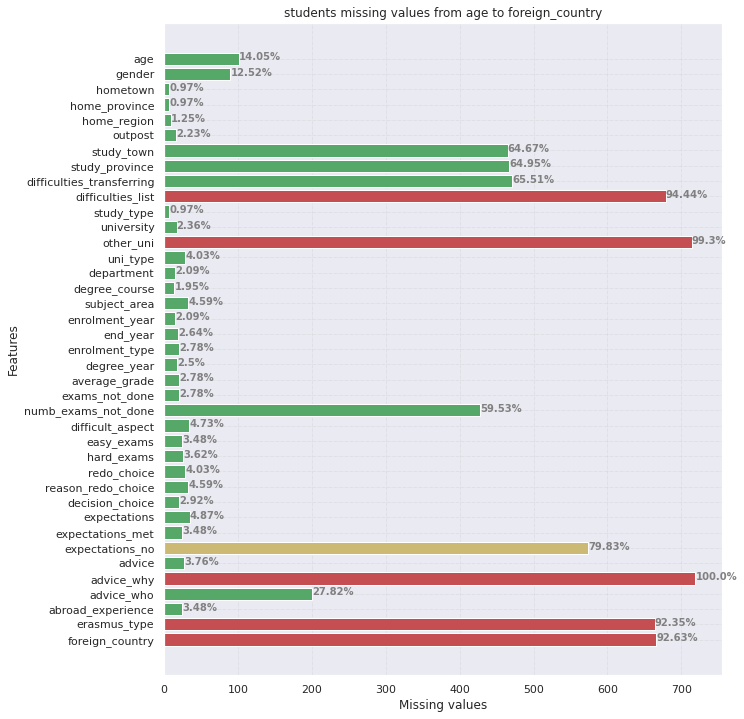

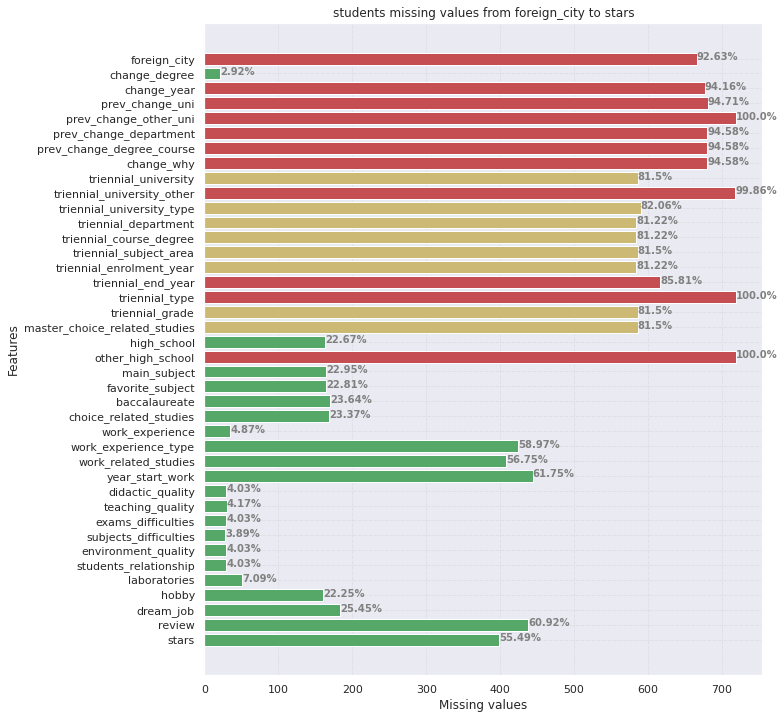

In [118]:
missing_value_graphs(df_missing_value_students, df_students, 'students')

##LAUREATI: grafico valori mancanti

61


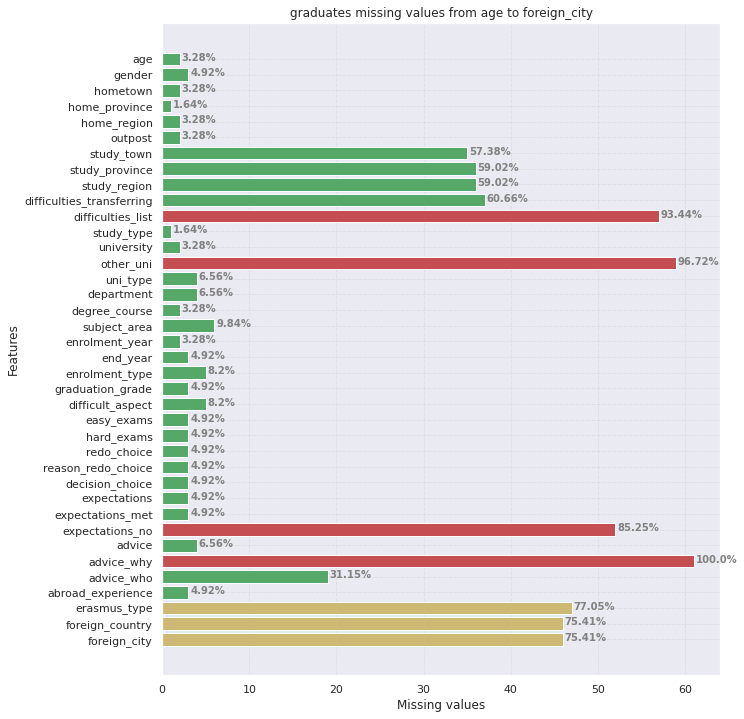

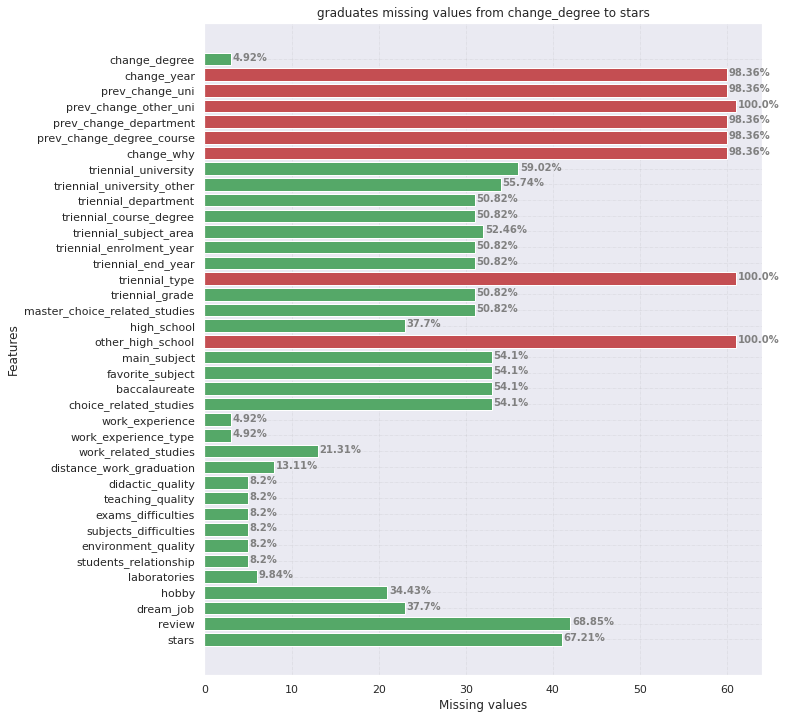

In [119]:
missing_value_graphs(df_missing_value_graduate, df_graduate, 'graduates')

#GESTIONE VALORI MANCANTI NELLA COLONNA UNIVERSITA'

##Studenti

###1 - Sostituzione altro con valore 'Nan'

In [120]:
df_students['university']=df_students['university'].replace('altro', np.NaN ) #necessario per effettuare merge tra 2 colonne
df_students.shape

(719, 79)

In [121]:
#TODO remove [fra]
df_students[['university', 'other_uni']].head(50) #codice di controllo

,university,other_uni
0,Politecnico di MILANO,NaN
1,Università degli Studi di NAPOLI Federico II,NaN
2,Università degli Studi di ROMA La Sapienza,NaN
3,Università degli Studi di ROMA La Sapienza,NaN
4,Università degli Studi di CAGLIARI,NaN
5,Università degli Studi di PARMA,NaN
6,NaN,"Civica Scuola di Cinema ""Luchino Visconti"""
7,Università degli Studi di BOLOGNA,NaN
8,Università degli Studi di PARMA,NaN
9,Università degli Studi di PARMA,NaN


###2- Merge tra la colonna university e other_uni per unire i valori mancanti in university

In [122]:
df_students['university']=df_students['university'].combine_first(df_students['other_uni'])
#df_students['university'].head(50)

### 3 - Eliminazione delle righe che nonostante il merge presentano valori nulli nella colonna university

In [123]:
df_students = df_students[df_students['university'].notna()]
df_students.shape

(696, 79)

##Laureati

### 1- Sostituzione altro con il valore 'Nan'

In [124]:

df_graduate['university']=df_graduate['university'].replace('altro', np.NaN ) #per poter fare il merge tra due colonne
df_graduate.shape

(61, 76)

In [125]:
#TODO remove [fra]
df_graduate.isnull().sum() #codice di controllo

age               2
gender            3
hometown          2
home_province     1
home_region       2
                 ..
laboratories      6
hobby            21
dream_job        23
review           42
stars            41
Length: 76, dtype: int64

In [126]:
#TODO remove [fra]
df_graduate[['university', 'other_uni']].head(50) #codice di controllo

,university,other_uni
0,Università degli Studi di PARMA,NaN
1,Università degli Studi di PARMA,NaN
2,Università degli Studi di PARMA,NaN
3,Università degli Studi di PARMA,NaN
4,Università degli Studi di VERONA,NaN
5,Università degli Studi di MODENA e REGGIO EMILIA,NaN
6,Università degli Studi di PARMA,NaN
7,Università degli Studi di NAPOLI Federico II,NaN
8,Università degli Studi di PADOVA,NaN
9,Università degli Studi di ROMA Foro Italico,NaN


### 2- Merge tra colonna university e other_uni

In [127]:
df_graduate['university']=df_graduate['university'].combine_first(df_graduate['other_uni'])
#df_graduate['university'].head(50)

###3- Eliminazione delle righe che contengono ancora 'Nan' nella colonna university

In [128]:
df_graduate = df_graduate[df_graduate['university'].notna()]
df_graduate.shape

(57, 76)

#DATI TRIENNALE E MAGISTRALE CICLO UNICO

<p>Selezionare le righe secondo una determinata condizione</p>
<a href="https://chrisalbon.com/python/data_wrangling/pandas_selecting_rows_on_conditions/"> https://chrisalbon.com/python/data_wrangling/pandas_selecting_rows_on_conditions/</a>

In [129]:
query_first_degree='study_type == "Triennale" | study_type == "Magistrale_unico"'
df_students_first_degree = df_students.query(query_first_degree)
df_graduate_first_degree = df_graduate.query(query_first_degree)
print('students first degree:',df_students_first_degree.shape)
print('graduates first degree:',df_graduate_first_degree.shape)


students first degree: (557, 79)
graduates first degree: (27, 76)


##ANALISI VALORI MANCANTI

In [130]:
df_missing_value_first_degree_students=df_students_first_degree.isnull().sum()
df_missing_value_first_degree_graduate=df_graduate_first_degree.isnull().sum()

###STUDENTI TRIENNALE E MAISTRALE A CICLO UNICO:grafico valori mancanti

557


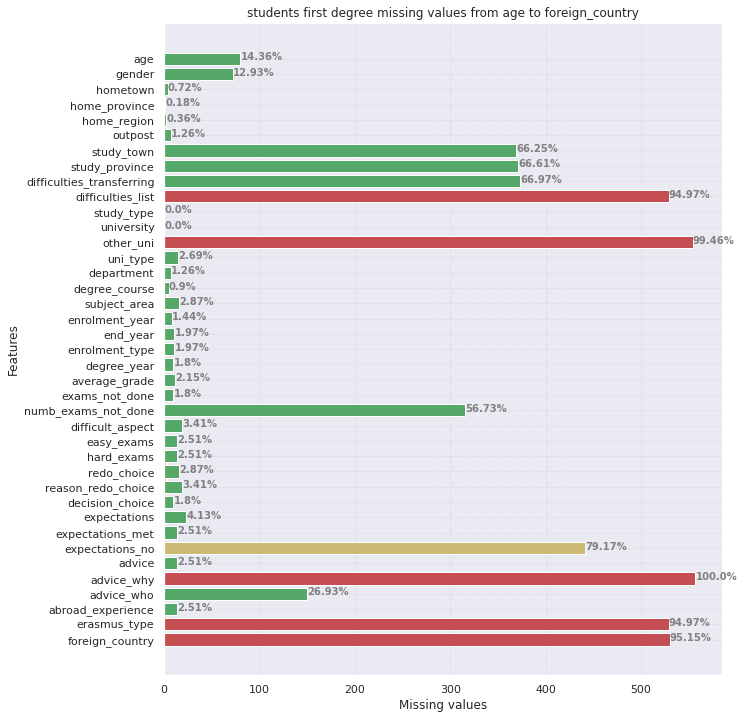

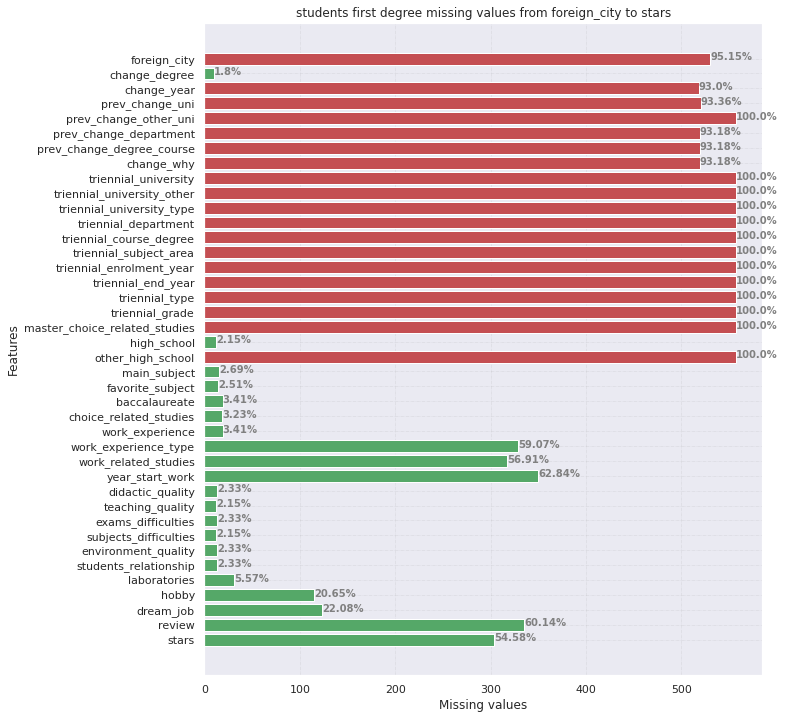

In [131]:
missing_value_graphs(df_missing_value_first_degree_students, df_students_first_degree, 'students first degree')

###LAUREATI TRIENNALE E MAGISTRALE A CICLO UNICO:grafico valori mancanti

27


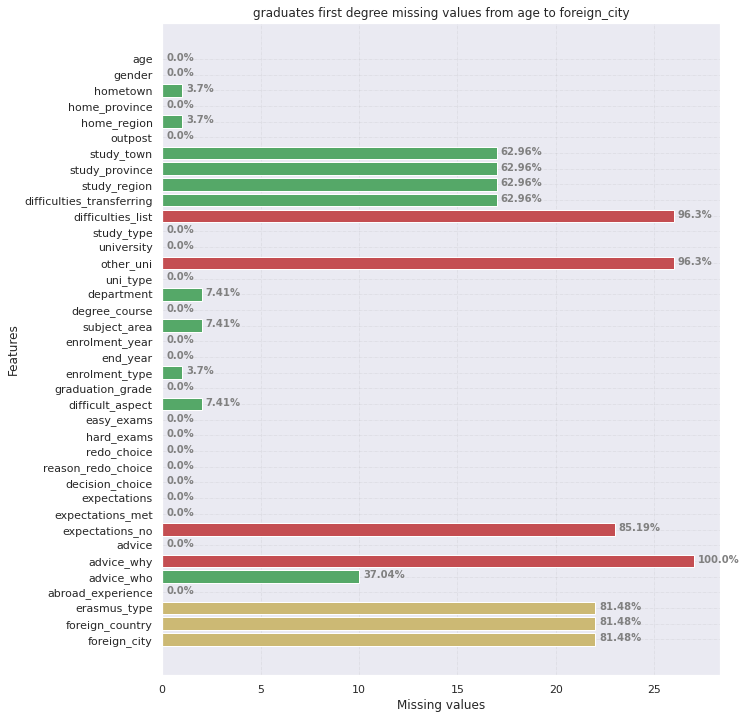

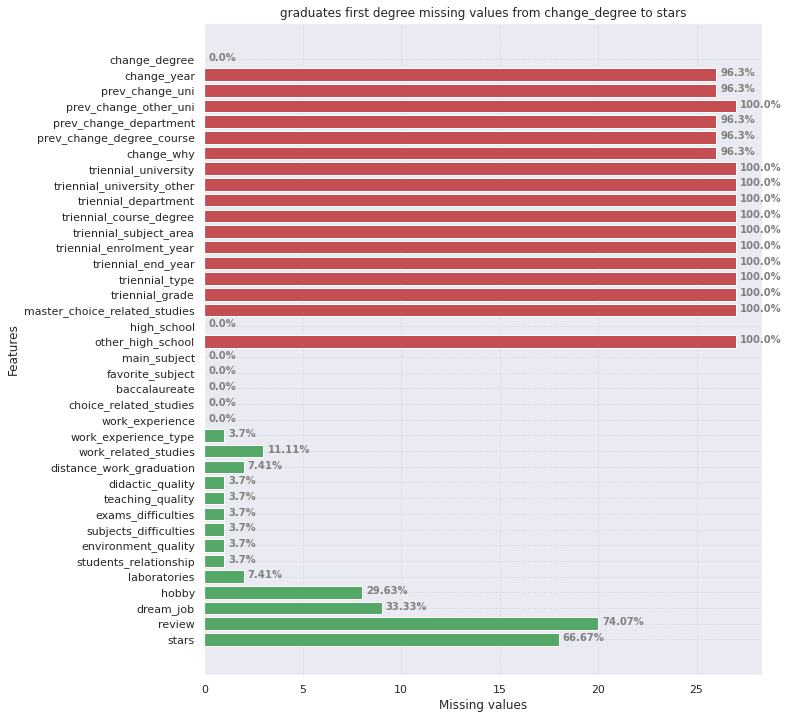

In [132]:
missing_value_graphs(df_missing_value_first_degree_graduate, df_graduate_first_degree, 'graduates first degree')

##FEATURES SELECTION

In [133]:
features_first_degree=['degree_course','other_high_school','high_school','main_subject', 'favorite_subject', 'dream_job', 'hobby', 'decision_choice' , 'expectations', 'choice_related_studies'  ]

##Unisco sia gli studenti che i laurati per le feature che ci interessano

In [134]:
all_features_dict={}
for feature in features_first_degree:
  all_features=df_students_first_degree[feature]
  all_features=all_features.append(df_graduate_first_degree[feature], ignore_index=True, verify_integrity=True)
  all_features_dict[feature]=all_features

df_all_features_first_degree=pd.DataFrame(all_features_dict)
print('original sample firt degree:',df_all_features_first_degree.shape[0] )
df_all_features_first_degree.head()

original sample firt degree: 584


,degree_course,other_high_school,high_school,main_subject,favorite_subject,dream_job,hobby,decision_choice,expectations,choice_related_studies
0,ingegneria aerospaziale,NaN,Liceo Scientifico,"Scienze,matematica,informatica",matematica,CERN o ASI,"Astronomia,musica","Passioni personali (spazio, meccanica, aerei etc)",NaN,SI
1,Economia e commercio,NaN,Liceo Scientifico,"matematica,fisica,scienze",matematica,consulente finanziario,videogiochi,la mia voglia di intraprendere questo percorso...,quello che sto vivendo,NO
2,Medicina,NaN,Liceo Classico,"Greco, latino,italiano",Non ne avevo una,Radiologo,"Ascoltare musica, vedere film",La predisposizione alla materia,Di riuscire a proseguire con facilità,NO
3,Medicina e chirurgia,NaN,Liceo Classico,"Latino, greco, italiano",Latino,Diventare un medico specializzato,Atletica,Ho sempre voluto fare questo mestiere,Sicuramente lungo e faticoso ma spero soddisfa...,NO
4,Infermieristica,NaN,Liceo Classico,"Greco, latino, italiano, letteratura, filosofia.",Filosofia,Infermiere di sala operatoria,"Musica (batteria), biliardo.",Il desiderio di poter dare una mano a chi ne h...,Tutto quello che ho effettivamente incontrato ...,NO


##GESTIONE VALORI MANCANTI

###eliminazione valori nulli

In [135]:
#conto valori nulli
df_all_features_first_degree.isnull().sum()

degree_course               5
other_high_school         584
high_school                12
main_subject               15
favorite_subject           14
dream_job                 132
hobby                     123
decision_choice            10
expectations               23
choice_related_studies     18
dtype: int64

In [136]:
for key in all_features_dict:
  if key!='main_subject' and key!='other_high_school':
    df_all_features_first_degree = df_all_features_first_degree[df_all_features_first_degree[key].notna()]
print('sample first degree after delete null value:',df_all_features_first_degree.shape[0])

sample first degree after delete null value: 413


###features main_subject gestione valori mancanti

In [137]:
school_whitout_subject= df_all_features_first_degree['high_school'].loc[df_all_features_first_degree['main_subject'].isnull()]

In [138]:
full_subject=df_all_features_first_degree['main_subject']
high_school=np.array(df_all_features_first_degree['high_school'])
for x  in school_whitout_subject:
  subject=np.array(df_all_features_first_degree['main_subject'].loc[df_all_features_first_degree['high_school'].str.contains(x,na=False)][0:1])
  for i in range(0, len(high_school)):
    if (high_school[i]==x):
        full_subject[i]=np.array2string(subject)
df_all_features_first_degree['full_subject']=full_subject

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [139]:
df_all_features_first_degree['main_subject']=df_all_features_first_degree['main_subject'].combine_first(df_all_features_first_degree['full_subject'])
df_all_features_first_degree[['main_subject', 'full_subject']].head(50)

,main_subject,full_subject
1,"matematica,fisica,scienze","matematica,fisica,scienze"
2,"Greco, latino,italiano","Greco, latino,italiano"
3,"Latino, greco, italiano","Latino, greco, italiano"
4,"Greco, latino, italiano, letteratura, filosofia.","Greco, latino, italiano, letteratura, filosofia."
5,"Diritto, economia inglese, francese, spagnolo","Diritto, economia inglese, francese, spagnolo"
6,"Latino,greco,italiano,inglese","['matematica,fisica,scienze']"
9,"Matematica,scienze,fisica,chimica","['matematica,fisica,scienze']"
10,"Economia, informatica","Economia, informatica"
11,"Matematica, fisica, italiano, chimica/scienze ...","Matematica, fisica, italiano, chimica/scienze ..."
12,"Matematica, fisica, chimica","Matematica, fisica, chimica"


In [140]:
df_all_features_first_degree=df_all_features_first_degree.drop(['full_subject'], axis=1) #elimino colonna d'appoggio

Eliminazione eventuali valori nulli rimasti ed aggiunta al dizionario con il resto delle colonne pulite

In [141]:
df_all_features_first_degree = df_all_features_first_degree[df_all_features_first_degree['main_subject'].notna()] #eliminazioni eventuali valori nulli rimasti
print('sample first degree after delete null value:',df_all_features_first_degree.shape[0])

sample first degree after delete null value: 412


In [142]:
original_df_whitout_nan_value=df_all_features_first_degree.copy()

##CLEANING TARGET VARIABLE (degree_course)

In [143]:
#acronimi
slang_degree_course={"ctf":"chimica e tecnologie farmaceutiche",
       "clemi": "economia e marketing internazionale", 
       "sztpa": "scienze zootecniche e tecnologie delle produzioni animali", 
       "smid": "statistica matematica e trattamento informatico dati", 
       "clei": "economia internazionale",
       "clem": "economia e marketing", 
       "cle": "economia", 
       "dams": "discipline delle arti della musica e dello spettacolo",
       "ctc": "chimica e tecnologie chimiche",
       "pmts": "planning management of tourism systems",
       "eifi":  "lingue moderne comunicazione cooperazione internazionale",
       "lms":  "letteratura musica spettacolo"
        }
regex_degree_course=[r'\sl.*[0-9]+', r'\scurriculum\s.*', r'indirizzo.*', r'[(].*[)]*', r'&', r'\s\s+', r'corso di laurea', r'ciclo unico', r'’']

###eliminazione valori nulli da degree course

In [144]:
df_all_features_first_degree=df_all_features_first_degree[df_all_features_first_degree['degree_course'].notna()]

###Cleaning valori

In [145]:
df_all_features_first_degree['degree_course']=data_cleaning(df_all_features_first_degree['degree_course'], regex_degree_course)
#sostituzione slang
for key in slang_degree_course.keys():
  df_all_features_first_degree.loc[df_all_features_first_degree['degree_course'].str.contains(key), 'degree_course'] = slang_degree_course[key]

#ulteriore pulizia manuale
df_all_features_first_degree.loc[df_all_features_first_degree['degree_course'].str.contains('medicina') & ~df_all_features_first_degree['degree_course'].str.contains('veterinaria'), 'degree_course'] = 'medicina e chirurgia'
df_all_features_first_degree.loc[df_all_features_first_degree['degree_course'].str.contains('informatica') & df_all_features_first_degree['degree_course'].str.contains('elettronica') & df_all_features_first_degree['degree_course'].str.contains('telecomunicazioni') , 'degree_course'] = 'ingegneria informatica elettronica e telecomunicazioni'
df_all_features_first_degree.loc[df_all_features_first_degree['degree_course'].str.contains('comunicazione e media per le industrie creative'), 'degree_course'] = 'comunicazione e media contemporanei per le industrie creative'
df_all_features_first_degree.loc[df_all_features_first_degree['degree_course'].str.contains('elettronica') & ~df_all_features_first_degree['degree_course'].str.contains('ingegneria' )& ~df_all_features_first_degree['degree_course'].str.contains('ing'), 'degree_course'] = 'ingegneria elettronica'
df_all_features_first_degree.loc[df_all_features_first_degree['degree_course'].str.contains('interfacce e tecnologie della comunicazion'), 'degree_course'] = 'interfacce uomo macchina e tecnologie della comunicazione'
df_all_features_first_degree.loc[df_all_features_first_degree['degree_course'].str.contains('letteratura musica e spettacolo'), 'degree_course'] = 'letteratura musica e spettacolo'
df_all_features_first_degree['degree_course']=df_all_features_first_degree['degree_course'].str.replace(r'(^ingegneria\s*)|(^ingegneria)', 'ing ')
df_all_features_first_degree['degree_course']=df_all_features_first_degree['degree_course'].str.replace('ingeneria ', 'ing ')
df_all_features_first_degree['degree_course']

1                        economia e commercio
2                        medicina e chirurgia
3                        medicina e chirurgia
4                             infermieristica
5      montaggio cinematografico e televisivo
                        ...                  
578                               informatica
579                                      ing 
580                      medicina e chirurgia
581                           scienze motorie
583               beni culturali e spettacolo
Name: degree_course, Length: 412, dtype: object

In [146]:
df_all_features_first_degree['degree_course']=preprocessing_text(df_all_features_first_degree, df_all_features_first_degree['degree_course'], 'degree_course', 'IT-EN')

In [147]:
unique_degree_course=np.unique(df_all_features_first_degree['degree_course'])
print(len(unique_degree_course))
print(unique_degree_course)

143
['archeolog' 'architettur' 'arti scienz spettacol' 'autom industrial'
 'ben artist spettacol' 'ben cultural' 'ben cultural spettacol' 'biolog'
 'biolog molecol' 'biotecnolog' 'chimic' 'chimic tecnolog chimic'
 'chimic tecnolog farmaceut' 'civilt lingu stran mod' 'comun'
 'comun med contemporane industr creativ' 'comun med pubblic' 'design'
 'design prodott industrial' 'dietist' 'digital marketing'
 'direzion impres' 'diritt tecnolog' 'disciplin arti music spettacol'
 'econom' 'econom amministr impres' 'econom aziendal' 'econom commerc'
 'econom finanz' 'econom internazional' 'econom management'
 'econom management nuov tecnolog digital'
 'econom marketing internazional' 'econom marketing management'
 'econom merc digital' 'econom merc istitu' 'economì management' 'farmac'
 'filosof' 'fisic' 'food system' 'gestion aziendal' 'giurisprudt'
 'infermierist' 'informat' 'ing' 'ing ambiental' 'ing biomed'
 'ing chimic material' 'ing civil ambiental edil' 'ing edil architettur'
 'ing edil c

##FEATURES CLEANING

###merge high school to other high school




In [148]:
df_all_features_first_degree['high_school']=df_all_features_first_degree['high_school'].replace('altro', np.NaN ) #necessario per effettuare merge tra 2 colonne


In [149]:
df_all_features_first_degree['high_school']=df_all_features_first_degree['high_school'].combine_first(df_all_features_first_degree['other_high_school'])

In [150]:
df_all_features_first_degree['high_school']=df_all_features_first_degree['high_school'].replace(np.NaN,'altro')

In [151]:
df_all_features_first_degree=df_all_features_first_degree.drop(['other_high_school'], axis=1) #elimino colonna d'appoggio
df_all_features_first_degree.head()

,degree_course,high_school,main_subject,favorite_subject,dream_job,hobby,decision_choice,expectations,choice_related_studies
1,econom commerc,Liceo Scientifico,"matematica,fisica,scienze",matematica,consulente finanziario,videogiochi,la mia voglia di intraprendere questo percorso...,quello che sto vivendo,NO
2,medicin chirurg,Liceo Classico,"Greco, latino,italiano",Non ne avevo una,Radiologo,"Ascoltare musica, vedere film",La predisposizione alla materia,Di riuscire a proseguire con facilità,NO
3,medicin chirurg,Liceo Classico,"Latino, greco, italiano",Latino,Diventare un medico specializzato,Atletica,Ho sempre voluto fare questo mestiere,Sicuramente lungo e faticoso ma spero soddisfa...,NO
4,infermierist,Liceo Classico,"Greco, latino, italiano, letteratura, filosofia.",Filosofia,Infermiere di sala operatoria,"Musica (batteria), biliardo.",Il desiderio di poter dare una mano a chi ne h...,Tutto quello che ho effettivamente incontrato ...,NO
5,montagg cinematograf televis,Istituto tecnico economico,"Diritto, economia inglese, francese, spagnolo",Diritto,Montatrice cinematografica,"Cinema, viaggi, lettura, arte, musica",La mia grande passione per il cinema,Mi aspettavo di riuscire ad imparare un mestie...,NO


###Controllo finale che non ci siano più valori nulli

In [152]:
df_all_features_first_degree.isnull().sum()

degree_course             0
high_school               0
main_subject              0
favorite_subject          0
dream_job                 0
hobby                     0
decision_choice           0
expectations              0
choice_related_studies    0
dtype: int64

###Cleaning dei dati

####dataset con dati puliti

In [153]:
df_clean_features=df_all_features_first_degree.copy()

In [154]:
categorical_features=['high_school', 'choice_related_studies']
regex_features=[r'\s\s+']
for feature in df_clean_features.columns:
  if feature != 'degree_course':
    df_clean_features[feature]=data_cleaning(df_clean_features[feature], regex_features)
    if feature not in categorical_features:
      df_clean_features[feature]=preprocessing_text(df_clean_features,df_clean_features[feature], feature, 'IT')

In [155]:
for feature in df_clean_features.columns: 
  display(pd.merge(df_all_features_first_degree[feature], df_clean_features[feature], right_index = True,left_index = True))

,degree_course_x,degree_course_y
1,econom commerc,econom commerc
2,medicin chirurg,medicin chirurg
3,medicin chirurg,medicin chirurg
4,infermierist,infermierist
5,montagg cinematograf televis,montagg cinematograf televis
...,...,...
578,informat,informat
579,ing,ing
580,medicin chirurg,medicin chirurg
581,scienz motor,scienz motor


,high_school_x,high_school_y
1,Liceo Scientifico,liceo scientifico
2,Liceo Classico,liceo classico
3,Liceo Classico,liceo classico
4,Liceo Classico,liceo classico
5,Istituto tecnico economico,istituto tecnico economico
...,...,...
578,Istituto tecnico industriale,istituto tecnico industriale
579,Istituto tecnico geometri,istituto tecnico geometri
580,Liceo Scientifico,liceo scientifico
581,Istituto tecnico economico,istituto tecnico economico


,main_subject_x,main_subject_y
1,"matematica,fisica,scienze",matemat fisic scienz
2,"Greco, latino,italiano",grec latin ital
3,"Latino, greco, italiano",latin grec ital
4,"Greco, latino, italiano, letteratura, filosofia.",grec latin ital letteratur filosof
5,"Diritto, economia inglese, francese, spagnolo",diritt econom ingles frances spagnol
...,...,...
578,"Matematica, Italiano, Sistemi e Reti, TPS (Tec...",matemat ital sistem ret tps tecnolog progett s...
579,"Costruzioni, topografia, disegno, tecnologia d...",costruzion topograf disegn tecnolog costruzion
580,Scienze,scienz
581,Ragioneria,ragioner


,favorite_subject_x,favorite_subject_y
1,matematica,matemat
2,Non ne avevo una,
3,Latino,latin
4,Filosofia,filosof
5,Diritto,diritt
...,...,...
578,Matematica,matemat
579,costruzioni,costruzion
580,Matematica,matemat
581,Italiano,ital


,dream_job_x,dream_job_y
1,consulente finanziario,consulent finanziar
2,Radiologo,radiolog
3,Diventare un medico specializzato,divent medic specializz
4,Infermiere di sala operatoria,inferm sal operator
5,Montatrice cinematografica,montatric cinematograf
...,...,...
578,Lavoro riguardante la CyberSecurity,lavor riguard cybersecurity
579,calcio professionistico (come allenatore),calc professionist allen
580,Medico,medic
581,Palestra salute,palestr sal


,hobby_x,hobby_y
1,videogiochi,videogioc
2,"Ascoltare musica, vedere film",ascolt music ved film
3,Atletica,atlet
4,"Musica (batteria), biliardo.",music batter biliard
5,"Cinema, viaggi, lettura, arte, musica",cinem viagg lettur arte music
...,...,...
578,"Leggere, ascoltare musica, guardare film",legg ascolt music guard film
579,"calcio, lettura",calc lettur
580,Nuoto,nuot
581,"Fotografia, animali",fotograf animal


,decision_choice_x,decision_choice_y
1,la mia voglia di intraprendere questo percorso...,vogl intraprend percors stud
2,La predisposizione alla materia,predisposizion mater
3,Ho sempre voluto fare questo mestiere,sempr vol far mest
4,Il desiderio di poter dare una mano a chi ne h...,desider poter dar man bisogn
5,La mia grande passione per il cinema,grand passion cinem
...,...,...
578,I miei genitori,genitor
579,Era la prosecuzione degli studi precedenti,prosecu stud precedent
580,X,x
581,Il mio interesse,interess


,expectations_x,expectations_y
1,quello che sto vivendo,viv
2,Di riuscire a proseguire con facilità,riusc prosegu facil
3,Sicuramente lungo e faticoso ma spero soddisfa...,sicur lung fatic sper soddisfacent fin
4,Tutto quello che ho effettivamente incontrato ...,effett incontr percors fors men mater umanist ...
5,Mi aspettavo di riuscire ad imparare un mestie...,aspett riusc impar mest molt cors pratic
...,...,...
578,Un approccio metodologico ai problemi,approcc metodolog problem
579,Quello che ho trovato,trov
580,X,x
581,Più pratica ma va bene così,pratic va ben cos


,choice_related_studies_x,choice_related_studies_y
1,NO,no
2,NO,no
3,NO,no
4,NO,no
5,NO,no
...,...,...
578,SI,si
579,SI,si
580,SI,si
581,NO,no


##FEATURE ENGINEERING DEGREE COURSE

In [156]:
tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
vectorize_matrix=tf_vector(tv, df_clean_features['degree_course'])
vectorize_matrix

,alimentar,ambient,ambiental,amministr,animal,archeolog,architettur,arti,artist,autom,aziendal,ben,biolog,biomed,biotecnolog,chimic,chirurg,cinematograf,civil,civilt,cognit,commerc,comun,contemporane,costruzion,creativ,cultur,cultural,dat,dentar,design,dietist,digital,direzion,diritt,disciplin,econom,economì,edil,ediliz,...,organizz,oriental,ostetric,polit,prevenzion,primar,process,prodott,produzion,profession,progett,protes,psicolog,pubblic,radiolog,radioterap,relazion,sal,sanitar,scienz,serviz,sistem,social,spettacol,statist,stor,stran,stud,system,tecnic,tecnolog,telecomun,televis,traduzion,tratt,turism,uman,uom,veterinar,zootecn
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.84,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.54,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.71,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.71,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.58,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.58,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
409,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.71,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.37,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [157]:
similarity_matrix = cosine_similarity(vectorize_matrix)
similarity_df = pd.DataFrame(similarity_matrix)
similarity_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.275195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.324455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.453466,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.358112,0.0,0.0,0.0,0.0,0.0,0.358112,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.358112,0.0,0.0,0.0,0.0,0.0,0.358112,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.888358,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


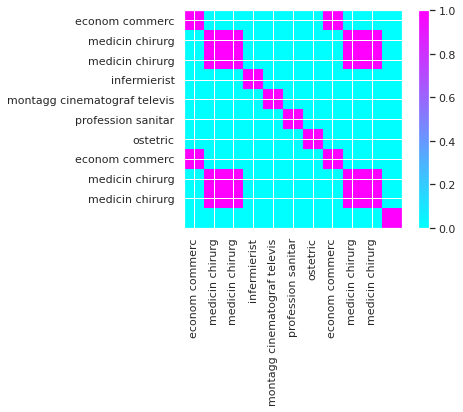

In [158]:
names=df_clean_features['degree_course'][0:10]
#subjects=['Maths','Hindi','English','Social Studies','Science','Computer Science']
 
plt.xticks(ticks=np.arange(len(names)),labels=names,rotation=90)
plt.yticks(ticks=np.arange(len(names)),labels=names)
# save this plot inside a variable called hm
hm=plt.imshow(similarity_df.loc[0:10, 0:10], cmap='cool',interpolation="nearest")
# pass this heatmap object into plt.colorbar method.
plt.colorbar(hm)

In [159]:
km = KMeans(n_clusters=120, random_state=0)
km.fit_transform(similarity_df)
cluster_labels = km.labels_
cluster_labels_degree_course = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
df_clean_features= df_clean_features.set_index(cluster_labels_degree_course.index) #evita che escano valori NAN a causa di index diversi
cluster_labels_degree_course.insert(0,'degree_course',df_clean_features['degree_course'], True)
original_df_whitout_nan_value= original_df_whitout_nan_value.set_index(cluster_labels_degree_course.index) #evita che escano valori NAN a causa di index diversi
cluster_labels_degree_course.insert(0,'full_degree_course',original_df_whitout_nan_value['degree_course'], True)
byCluster=cluster_labels_degree_course.groupby(['ClusterLabel'])


/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


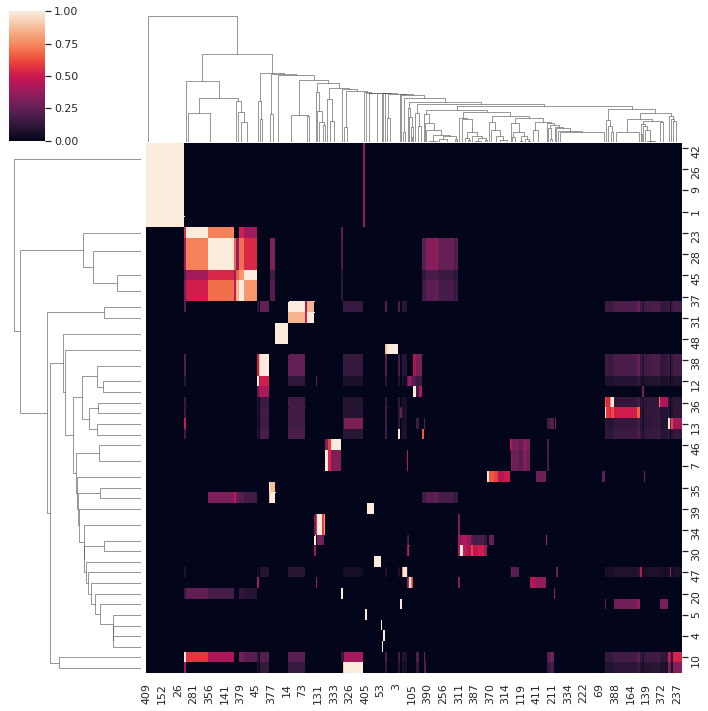

In [160]:
sns.set_theme(color_codes=True)
g = sns.clustermap(similarity_df[0:50])

In [161]:
labels = []
for cluster, degree in byCluster:
    print(f"All entries for {cluster!r}")
    print("------------------------")
    print(degree, end="\n\n")   #display(degree)
    labels.append(degree['full_degree_course'].iloc[0])
print(labels)

All entries for 0
------------------------
                                full_degree_course  ... ClusterLabel
33           Mediazione Linguistica Interculturale  ...            0
34           Mediazione linguistica interculturale  ...            0
121          Mediazione linguistica interculturale  ...            0
131         Mediazione linguistica interculturale   ...            0
260  Mediazione Interlinguistica e interculturale   ...            0
378                        Mediazioni linguistiche  ...            0

[6 rows x 3 columns]

All entries for 1
------------------------
        full_degree_course degree_course  ClusterLabel
185  Scienze Motorie  L-22  scienz motor             1
410        Scienze motorie  scienz motor             1

All entries for 2
------------------------
            full_degree_course degree_course  ClusterLabel
28      Ingegneria informatica  ing informat             2
29      Ingegneria Informatica  ing informat             2
32      Ingegneria inf

In [162]:
df_clean_features=df_clean_features.set_index(cluster_labels_degree_course.index)
df_clean_features['degree_course']=cluster_labels_degree_course['ClusterLabel']
print('check if add missing values:', df_clean_features['degree_course'].isnull().sum())

check if add missing values: 0


#FEATURES ENGINEERING

###Caratteristiche nominali -> choice_related_studies

In [163]:
for feature in categorical_features:
  df_clean_features[feature]=one_hot_encoding( df_clean_features[feature], feature)

encoding high_school : {0: 'altro', 1: 'ipsia', 2: 'istituto professionale agrario ', 3: 'istituto professionale alberghiero', 4: 'istituto professionale economico ', 5: 'istituto tecnico agrario', 6: 'istituto tecnico alberghiero', 7: 'istituto tecnico economico', 8: 'istituto tecnico geometri', 9: 'istituto tecnico industriale', 10: 'liceo artistico', 11: 'liceo classico', 12: 'liceo linguistico', 13: 'liceo musicale', 14: 'liceo scientifico', 15: 'liceo scienze umane'}
encoding choice_related_studies : {0: 'no', 1: 'si'}


##caratteristiche testuali->bag of words


In [164]:
df_bow_dict={}
feature_bow=['main_subject', 'hobby' , 'favorite_subject', 'dream_job' ]
vectorizer_train = CountVectorizer(min_df=0, binary=True)
for feature in feature_bow:
  df_bof=bag_of_words(vectorizer_train, df_clean_features[feature])
  df_bow_dict[feature]=df_bof
  df_clean_features=df_clean_features.drop([feature], axis=1)

  print('sample of', feature , 'after merge row:', df_clean_features.shape[0])
  print('sample of', feature , 'after merge coloumns:', df_clean_features.shape[1])
  print('sample  of', feature , 'after bag of words:', df_bof.shape[0])
  print(df_bow_dict[feature].head())

sample of main_subject after merge row: 412
sample of main_subject after merge coloumns: 8
sample  of main_subject after bag of words: 412
   accoglit  agrar  agroforestal  agronom  ...  vit  viticoltur  world  zootecn
0         0      0             0        0  ...    0           0      0        0
1         0      0             0        0  ...    0           0      0        0
2         0      0             0        0  ...    0           0      0        0
3         0      0             0        0  ...    0           0      0        0
4         0      0             0        0  ...    0           0      0        0

[5 rows x 200 columns]
sample of hobby after merge row: 412
sample of hobby after merge coloumns: 7
sample  of hobby after bag of words: 412
   118  3d  abbandon  acquerell  adess  ...  wars  web  workout  yog  zon
0    0   0         0          0      0  ...     0    0        0    0    0
1    0   0         0          0      0  ...     0    0        0    0    0
2    0   0       

In [165]:
df_clean_features.head()

,degree_course,high_school,decision_choice,expectations,choice_related_studies
0,52,14,vogl intraprend percors stud,viv,0
1,3,11,predisposizion mater,riusc prosegu facil,0
2,3,11,sempr vol far mest,sicur lung fatic sper soddisfacent fin,0
3,16,11,desider poter dar man bisogn,effett incontr percors fors men mater umanist ...,0
4,106,7,grand passion cinem,aspett riusc impar mest molt cors pratic,0


In [166]:
for key in df_bow_dict.keys():
  print(key)
  print('columns:', df_bow_dict[key].shape[1])
  df_clean_features=df_clean_features.set_index(df_bow_dict[key].index)
  df_clean_features=pd.concat([df_clean_features,  df_bow_dict[key]], axis=1)
  #df_clean_features=pd.merge(df_clean_features, df_bow_dict[key], left_index=True, right_index=True)
  print(df_clean_features.shape)

main_subject
columns: 200
(412, 205)
hobby
columns: 362
(412, 567)
favorite_subject
columns: 115
(412, 682)
dream_job
columns: 503
(412, 1185)


In [167]:
df_clean_features.head()

,degree_course,high_school,decision_choice,expectations,choice_related_studies,accoglit,agrar,agroforestal,agronom,aliment,ambient,ambiental,analis,analit,anatom,and,animal,antropolog,applic,architettur,arte,artist,arts,attenzion,audiovis,autocad,autom,automat,avanz,avvis,aziendal,bar,biochim,biolog,biotecnolog,cant,chimic,cines,class,composizion,...,tecnic,tecnolog,tester,therapist,therapy,tip,tour,traduttor,traduttr,trainer,trann,tropp,truduttr,turism,turist,tutel,tutist,tv,unesc,unir,univers,universitar,urgent,urgenz,valorizz,vend,veterinar,viagg,vide,videogioc,videolud,viss,visual,viv,vogl,vol,vorre,web,york,zon
0,52,14,vogl intraprend percors stud,viv,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3,11,predisposizion mater,riusc prosegu facil,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,11,sempr vol far mest,sicur lung fatic sper soddisfacent fin,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,16,11,desider poter dar man bisogn,effett incontr percors fors men mater umanist ...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,106,7,grand passion cinem,aspett riusc impar mest molt cors pratic,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [168]:
df_clean_features.isnull().sum()

degree_course             0
high_school               0
decision_choice           0
expectations              0
choice_related_studies    0
                         ..
vol                       0
vorre                     0
web                       0
york                      0
zon                       0
Length: 1185, dtype: int64

##Caratteristiche testuali-> Tfid

In [169]:
df_tf_id_dict={}
feature_tf_id=['expectations', 'decision_choice']
tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
for feature in feature_tf_id:
  df_tf_id=tf_vector(tv, df_clean_features[feature])
  df_tf_id_dict[feature]=df_tf_id
  df_clean_features=df_clean_features.drop([feature], axis=1)

  print('sample of', feature , 'after merge row:', df_clean_features.shape[0])
  print('sample of', feature , 'after merge coloumns:', df_clean_features.shape[1])
  print('sample  of', feature , 'after tf if of words:', df_tf_id.shape[0])
  print(df_tf_id_dict[feature].head())

sample of expectations after merge row: 412
sample of expectations after merge coloumns: 1184
sample  of expectations after tf if of words: 412
   360  abbast  abilit  acced  accoglient  ...  vol  volont  volt  vorre  vot
0  0.0     0.0     0.0    0.0         0.0  ...  0.0     0.0   0.0    0.0  0.0
1  0.0     0.0     0.0    0.0         0.0  ...  0.0     0.0   0.0    0.0  0.0
2  0.0     0.0     0.0    0.0         0.0  ...  0.0     0.0   0.0    0.0  0.0
3  0.0     0.3     0.0    0.0         0.0  ...  0.0     0.0   0.0    0.0  0.0
4  0.0     0.0     0.0    0.0         0.0  ...  0.0     0.0   0.0    0.0  0.0

[5 rows x 695 columns]
sample of decision_choice after merge row: 412
sample of decision_choice after merge coloumns: 1183
sample  of decision_choice after tf if of words: 412
    15  2015   25  abbast  abil  ...  vorreu  youtub  zon  zoolog  zootecn
0  0.0   0.0  0.0     0.0   0.0  ...     0.0     0.0  0.0     0.0      0.0
1  0.0   0.0  0.0     0.0   0.0  ...     0.0     0.0  0.0    

In [170]:
for key in df_tf_id_dict.keys():
  print(key)
  print('columns:', df_tf_id_dict[key].shape[1])
  df_clean_features=df_clean_features.set_index(df_tf_id_dict[key].index)
  df_clean_features=pd.concat([df_clean_features,  df_tf_id_dict[key]], axis=1)
  #df_clean_features=pd.merge(df_clean_features, df_bow_dict[key], left_index=True, right_index=True)
  print(df_clean_features.shape)

expectations
columns: 695
(412, 1878)
decision_choice
columns: 608
(412, 2486)


In [171]:
df_clean_features.head()

,degree_course,high_school,choice_related_studies,accoglit,agrar,agroforestal,agronom,aliment,ambient,ambiental,analis,analit,anatom,and,animal,antropolog,applic,architettur,arte,artist,arts,attenzion,audiovis,autocad,autom,automat,avanz,avvis,aziendal,bar,biochim,biolog,biotecnolog,cant,chimic,cines,class,composizion,confezion,contattolog,...,trienn,triennal,tropp,trov,turism,tutt,ultim,uman,umanist,unib,unic,unir,univers,universitar,uscit,util,variet,ved,ven,veng,vers,veterinar,via,viagg,vide,vist,vit,vocazion,vogl,vol,volentier,voler,volont,volontar,vorre,vorreu,youtub,zon,zoolog,zootecn
0,52,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,16,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,106,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [172]:
df_clean_features.isnull().sum()

degree_course             0
high_school               0
choice_related_studies    0
accoglit                  0
agrar                     0
                         ..
vorreu                    0
youtub                    0
zon                       0
zoolog                    0
zootecn                   0
Length: 2486, dtype: int64

#DEFINISCO TRAIN SET E TEST SET

In [173]:
#MAIN SUBJECT DATASET
X=df_clean_features.iloc[:, 1:]
y=df_clean_features['degree_course']



In [174]:
X

,high_school,choice_related_studies,accoglit,agrar,agroforestal,agronom,aliment,ambient,ambiental,analis,analit,anatom,and,animal,antropolog,applic,architettur,arte,artist,arts,attenzion,audiovis,autocad,autom,automat,avanz,avvis,aziendal,bar,biochim,biolog,biotecnolog,cant,chimic,cines,class,composizion,confezion,contattolog,convers,...,trienn,triennal,tropp,trov,turism,tutt,ultim,uman,umanist,unib,unic,unir,univers,universitar,uscit,util,variet,ved,ven,veng,vers,veterinar,via,viagg,vide,vist,vit,vocazion,vogl,vol,volentier,voler,volont,volontar,vorre,vorreu,youtub,zon,zoolog,zootecn
0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
408,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
409,14,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
410,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [175]:
y

0       52
1        3
2        3
3       16
4      106
      ... 
407     15
408     38
409      3
410      1
411     51
Name: degree_course, Length: 412, dtype: int32

#BILANCIAMENTO DELLE CLASSI: OVERSAMPLE

In [176]:
print(Counter(y))
oversample = RandomOverSampler(sampling_strategy='auto')
X, y= oversample.fit_resample(X, y)
print(Counter(y))

Counter({3: 30, 2: 20, 7: 18, 15: 17, 5: 15, 6: 13, 14: 10, 12: 10, 13: 9, 16: 8, 51: 8, 22: 7, 26: 7, 20: 7, 34: 6, 0: 6, 25: 6, 41: 6, 50: 6, 28: 5, 31: 5, 55: 5, 23: 5, 39: 5, 68: 4, 32: 4, 33: 4, 46: 4, 8: 4, 65: 4, 10: 4, 19: 4, 57: 4, 42: 3, 98: 3, 73: 3, 47: 3, 104: 3, 36: 3, 40: 3, 67: 3, 74: 3, 27: 3, 43: 3, 30: 3, 29: 3, 52: 2, 44: 2, 17: 2, 45: 2, 60: 2, 37: 2, 49: 2, 59: 2, 63: 2, 61: 2, 76: 2, 62: 2, 96: 2, 72: 2, 58: 2, 56: 2, 66: 2, 71: 2, 53: 2, 95: 2, 1: 2, 116: 2, 79: 2, 38: 2, 70: 2, 64: 2, 75: 2, 84: 2, 35: 2, 106: 1, 115: 1, 109: 1, 48: 1, 88: 1, 18: 1, 85: 1, 24: 1, 80: 1, 69: 1, 93: 1, 99: 1, 54: 1, 92: 1, 108: 1, 83: 1, 9: 1, 103: 1, 119: 1, 111: 1, 81: 1, 101: 1, 107: 1, 94: 1, 102: 1, 114: 1, 11: 1, 89: 1, 97: 1, 112: 1, 21: 1, 118: 1, 90: 1, 86: 1, 117: 1, 82: 1, 105: 1, 77: 1, 110: 1, 87: 1, 78: 1, 113: 1, 91: 1, 4: 1, 100: 1})
Counter({52: 30, 3: 30, 16: 30, 106: 30, 115: 30, 109: 30, 48: 30, 42: 30, 88: 30, 18: 30, 14: 30, 85: 30, 68: 30, 24: 30, 28: 30, 4

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


#CREAZIONE DEL TRAIN SET E DEL TEST SET

In [177]:
X_train_20, X_test_20, y_train_20, y_test_20 = train_test_split(X, y, test_size=0.20, random_state=42)

In [178]:
X_train_33, X_test_33, y_train_33, y_test_33 = train_test_split(X, y, test_size=0.33, random_state=42)

In [179]:
X_train_50, X_test_50, y_train_50, y_test_50 = train_test_split(X, y, test_size=0.50, random_state=42)

In [180]:
X_train_66, X_test_66, y_train_66, y_test_66 = train_test_split(X, y, test_size=0.66, random_state=42)

In [ ]:
#X_train_list=[X_train_20, X_train_33, X_train_50, X_train_66]

#ADDESTRAMENTO E CLASSIFICAZIONE

##Ensemble Voting

In [181]:
# initializing all the model objects with default parameters
model_1 = GaussianNB()
model_2 = DecisionTreeClassifier()
model_3 = RandomForestClassifier()


In [182]:
# Making the final model using voting classifier
voting_model = VotingClassifier(
    estimators=[('gb', model_1), ('dt', model_2), ('rf', model_3)], voting='hard')
  
voting_predict={}
voting_score={}

###primo train set

In [183]:
predict=fit_dataset(voting_model, X_train_20, y_train_20, X_test_20)
voting_predict['test_20%']=predict

score=score_dataset(voting_model, X_train_20, y_train_20, X_test_20, y_test_20)
voting_score['test_20%']=score



In [184]:
count=wrong_classification(X_test_20, voting_predict['test_20%'], y_test_20)
voting_score['test_20%']['wrong_class']=count

14 has been classified as  6 and should be  5
199 has been classified as  2 and should be  15
214 has been classified as  84 and should be  3
278 has been classified as  7 and should be  3
320 has been classified as  15 and should be  2
647 has been classified as  6 and should be  5


###secondo train set

In [185]:
predict=fit_dataset(voting_model, X_train_33, y_train_33, X_test_33)
voting_predict['test_33%']=predict

score=score_dataset(voting_model, X_train_33, y_train_33, X_test_33, y_test_33)
voting_score['test_33%']=score



In [186]:
count=wrong_classification(X_test_33, voting_predict['test_33%'], y_test_33)
voting_score['test_33%']['wrong_class']=count

14 has been classified as  35 and should be  5
43 has been classified as  15 and should be  2
199 has been classified as  2 and should be  15
214 has been classified as  84 and should be  3
278 has been classified as  14 and should be  3
320 has been classified as  15 and should be  2
387 has been classified as  51 and should be  7
476 has been classified as  12 and should be  13
533 has been classified as  1 and should be  5
578 has been classified as  2 and should be  33
647 has been classified as  35 and should be  5
741 has been classified as  15 and should be  2
757 has been classified as  3 and should be  6
803 has been classified as  3 and should be  6
864 has been classified as  3 and should be  15
883 has been classified as  13 and should be  15
891 has been classified as  32 and should be  22
904 has been classified as  32 and should be  22
906 has been classified as  32 and should be  22
966 has been classified as  2 and should be  12
971 has been classified as  13 and shoul

### terzo train set

In [187]:
predict=fit_dataset(voting_model, X_train_50 , y_train_50, X_test_50)
voting_predict['test_50%']=predict

score=score_dataset(voting_model, X_train_50, y_train_50, X_test_50, y_test_50)
voting_score['test_50%']=score



In [188]:
count=wrong_classification(X_test_50, voting_predict['test_50%'], y_test_50)
voting_score['test_50%']['wrong_class']=count

14 has been classified as  3 and should be  5
43 has been classified as  15 and should be  2
60 has been classified as  26 and should be  51
105 has been classified as  37 and should be  22
108 has been classified as  31 and should be  51
184 has been classified as  57 and should be  16
195 has been classified as  81 and should be  6
199 has been classified as  3 and should be  15
214 has been classified as  84 and should be  3
227 has been classified as  15 and should be  13
278 has been classified as  23 and should be  3
320 has been classified as  15 and should be  2
363 has been classified as  3 and should be  15
387 has been classified as  50 and should be  7
452 has been classified as  15 and should be  13
476 has been classified as  2 and should be  13
527 has been classified as  57 and should be  16
533 has been classified as  1 and should be  5
545 has been classified as  3 and should be  51
578 has been classified as  2 and should be  33
645 has been classified as  3 and shou

### quarto train set

In [189]:
predict=fit_dataset(voting_model, X_train_66, y_train_66, X_test_66)
voting_predict['test_66%']=predict

score=score_dataset(voting_model, X_train_66, y_train_66, X_test_66, y_test_66)
voting_score['test_66%']=score

In [190]:
count=wrong_classification(X_test_66, voting_predict['test_66%'], y_test_66)
voting_score['test_66%']['wrong_class']=count

14 has been classified as  35 and should be  5
60 has been classified as  6 and should be  51
62 has been classified as  71 and should be  46
97 has been classified as  90 and should be  8
105 has been classified as  7 and should be  22
108 has been classified as  31 and should be  51
134 has been classified as  2 and should be  40
135 has been classified as  16 and should be  33
137 has been classified as  15 and should be  12
184 has been classified as  50 and should be  16
195 has been classified as  0 and should be  6
199 has been classified as  2 and should be  15
210 has been classified as  57 and should be  16
214 has been classified as  84 and should be  3
220 has been classified as  90 and should be  8
227 has been classified as  116 and should be  13
233 has been classified as  2 and should be  23
244 has been classified as  46 and should be  73
262 has been classified as  3 and should be  13
276 has been classified as  5 and should be  25
278 has been classified as  2 and sh

In [191]:
voting_score_df=pd.DataFrame(voting_score)
voting_score_df

,test_20%,test_33%,test_50%,test_66%
score_train_set,1.000000,1.000000,1.000,1.000000
score_test_set,0.991667,0.974747,0.965,0.929293
lengh_train_set,2880.000000,2412.000000,1800.000,1224.000000
lengh_test_set,720.000000,1188.000000,1800.000,2376.000000
wrong_class,6.000000,30.000000,63.000,168.000000


##Ensemble Bagging 

In [192]:
# Making the final model using bagging classifier
bagging_model = BaggingClassifier(
    base_estimator=None,n_estimators=10,random_state=0)
  
bagging_predict={}
bagging_score={}

###primo train set

In [193]:
predict=fit_dataset(bagging_model, X_train_20, y_train_20, X_test_20)
bagging_predict['test_20%']=predict

score=score_dataset(bagging_model, X_train_20, y_train_20, X_test_20, y_test_20)
bagging_score['test_20%']=score


In [194]:
count=wrong_classification(X_test_20, bagging_predict['test_20%'], y_test_20)
bagging_score['test_20%']['wrong_class']=count

11 has been classified as  34 and should be  3
14 has been classified as  35 and should be  5
43 has been classified as  12 and should be  2
199 has been classified as  12 and should be  15
214 has been classified as  84 and should be  3
278 has been classified as  14 and should be  3
320 has been classified as  114 and should be  2
363 has been classified as  7 and should be  15
475 has been classified as  66 and should be  3
526 has been classified as  22 and should be  7
603 has been classified as  22 and should be  7
647 has been classified as  35 and should be  5


###secondo train set

In [195]:
predict=fit_dataset(bagging_model, X_train_33, y_train_33, X_test_33)
bagging_predict['test_33%']=predict

score=score_dataset(bagging_model, X_train_33, y_train_33, X_test_33, y_test_33)
bagging_score['test_33%']=score

In [196]:
count=wrong_classification(X_test_33, bagging_predict['test_33%'], y_test_33)
bagging_score['test_33%']['wrong_class']=count

11 has been classified as  19 and should be  3
13 has been classified as  12 and should be  2
14 has been classified as  6 and should be  5
43 has been classified as  12 and should be  2
199 has been classified as  12 and should be  15
214 has been classified as  84 and should be  3
278 has been classified as  111 and should be  3
299 has been classified as  35 and should be  5
320 has been classified as  8 and should be  2
331 has been classified as  35 and should be  5
363 has been classified as  12 and should be  15
387 has been classified as  72 and should be  7
476 has been classified as  105 and should be  13
526 has been classified as  72 and should be  7
533 has been classified as  24 and should be  5
578 has been classified as  2 and should be  33
603 has been classified as  72 and should be  7
647 has been classified as  6 and should be  5
741 has been classified as  12 and should be  2
757 has been classified as  25 and should be  6
803 has been classified as  25 and should 

###terzo train set

In [197]:
predict=fit_dataset(bagging_model, X_train_50 , y_train_50, X_test_50)
bagging_predict['test_50%']=predict

score=score_dataset(bagging_model, X_train_50, y_train_50, X_test_50, y_test_50)
bagging_score['test_50%']=score


In [198]:
count=wrong_classification(X_test_50, bagging_predict['test_50%'], y_test_50)
bagging_score['test_50%']['wrong_class']=count

11 has been classified as  34 and should be  3
13 has been classified as  46 and should be  2
14 has been classified as  35 and should be  5
43 has been classified as  15 and should be  2
58 has been classified as  10 and should be  0
60 has been classified as  7 and should be  51
105 has been classified as  37 and should be  22
108 has been classified as  31 and should be  51
184 has been classified as  30 and should be  16
195 has been classified as  0 and should be  6
199 has been classified as  12 and should be  15
210 has been classified as  7 and should be  16
214 has been classified as  84 and should be  3
227 has been classified as  15 and should be  13
278 has been classified as  16 and should be  3
320 has been classified as  15 and should be  2
363 has been classified as  61 and should be  15
387 has been classified as  72 and should be  7
452 has been classified as  15 and should be  13
476 has been classified as  12 and should be  13
526 has been classified as  72 and shou

###quarto train set

In [199]:
predict=fit_dataset(bagging_model, X_train_66, y_train_66, X_test_66)
bagging_predict['test_66%']=predict

score=score_dataset(bagging_model, X_train_66, y_train_66, X_test_66, y_test_66)
bagging_score['test_66%']=score

In [200]:
count=wrong_classification(X_test_66, bagging_predict['test_66%'], y_test_66)
bagging_score['test_66%']['wrong_class']=count

13 has been classified as  15 and should be  2
14 has been classified as  35 and should be  5
43 has been classified as  68 and should be  2
60 has been classified as  67 and should be  51
62 has been classified as  3 and should be  46
97 has been classified as  2 and should be  8
105 has been classified as  37 and should be  22
108 has been classified as  31 and should be  51
134 has been classified as  2 and should be  40
135 has been classified as  88 and should be  33
137 has been classified as  15 and should be  12
184 has been classified as  57 and should be  16
195 has been classified as  81 and should be  6
199 has been classified as  12 and should be  15
206 has been classified as  1 and should be  7
210 has been classified as  57 and should be  16
214 has been classified as  84 and should be  3
220 has been classified as  2 and should be  8
227 has been classified as  68 and should be  13
233 has been classified as  3 and should be  23
244 has been classified as  12 and shoul

In [201]:
bagging_score_df=pd.DataFrame(bagging_score)
bagging_score_df

,test_20%,test_33%,test_50%,test_66%
score_train_set,0.999653,0.999171,1.000000,1.000000
score_test_set,0.983333,0.968013,0.956111,0.922559
lengh_train_set,2880.000000,2412.000000,1800.000000,1224.000000
lengh_test_set,720.000000,1188.000000,1800.000000,2376.000000
wrong_class,12.000000,38.000000,79.000000,184.000000


##Ensemble Boosting

In [202]:
# Making the final model using boosting classifier
boosting_model = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, max_depth=1, random_state=0)
  
boosting_predict={}
boosting_score={}

###primo train set


In [203]:
predict=fit_dataset(boosting_model, X_train_20, y_train_20, X_test_20)
boosting_predict['test_20%']=predict

score=score_dataset(boosting_model, X_train_20, y_train_20, X_test_20, y_test_20)
boosting_score['test_20%']=score

In [204]:
count=wrong_classification(X_test_20, boosting_predict['test_20%'], y_test_20)
boosting_score['test_20%']['wrong_class']=count

11 has been classified as  50 and should be  3
13 has been classified as  46 and should be  2
14 has been classified as  35 and should be  5
19 has been classified as  31 and should be  62
43 has been classified as  50 and should be  2
50 has been classified as  31 and should be  62
80 has been classified as  50 and should be  31
102 has been classified as  31 and should be  62
105 has been classified as  50 and should be  22
150 has been classified as  50 and should be  68
192 has been classified as  25 and should be  50
195 has been classified as  50 and should be  6
199 has been classified as  12 and should be  15
206 has been classified as  50 and should be  7
210 has been classified as  50 and should be  16
214 has been classified as  84 and should be  3
243 has been classified as  50 and should be  6
251 has been classified as  50 and should be  12
255 has been classified as  50 and should be  3
276 has been classified as  50 and should be  25
278 has been classified as  7 and sh

###secondo train set

In [205]:
predict=fit_dataset(boosting_model, X_train_33, y_train_33, X_test_33)
boosting_predict['test_33%']=predict

score=score_dataset(boosting_model, X_train_33, y_train_33, X_test_33, y_test_33)
boosting_score['test_33%']=score

In [206]:
count=wrong_classification(X_test_33, boosting_predict['test_33%'], y_test_33)
boosting_score['test_33%']['wrong_class']=count

11 has been classified as  22 and should be  3
13 has been classified as  46 and should be  2
14 has been classified as  22 and should be  5
24 has been classified as  3 and should be  35
36 has been classified as  3 and should be  35
43 has been classified as  22 and should be  2
80 has been classified as  22 and should be  31
98 has been classified as  22 and should be  35
199 has been classified as  13 and should be  15
204 has been classified as  3 and should be  35
210 has been classified as  22 and should be  16
214 has been classified as  84 and should be  3
278 has been classified as  22 and should be  3
299 has been classified as  22 and should be  5
315 has been classified as  22 and should be  35
320 has been classified as  22 and should be  2
328 has been classified as  82 and should be  16
331 has been classified as  22 and should be  5
334 has been classified as  22 and should be  15
363 has been classified as  22 and should be  15
388 has been classified as  22 and shoul

###terzo train set

In [207]:
predict=fit_dataset(boosting_model, X_train_50 , y_train_50, X_test_50)
boosting_predict['test_50%']=predict

score=score_dataset(boosting_model, X_train_50, y_train_50, X_test_50, y_test_50)
boosting_score['test_50%']=score

In [208]:
count=wrong_classification(X_test_50, boosting_predict['test_50%'], y_test_50)
boosting_score['test_50%']['wrong_class']=count

0 has been classified as  35 and should be  39
1 has been classified as  35 and should be  49
2 has been classified as  35 and should be  118
3 has been classified as  35 and should be  119
4 has been classified as  35 and should be  30
5 has been classified as  35 and should be  117
6 has been classified as  35 and should be  44
7 has been classified as  35 and should be  34
8 has been classified as  35 and should be  87
9 has been classified as  35 and should be  54
10 has been classified as  35 and should be  75
11 has been classified as  35 and should be  3
12 has been classified as  35 and should be  23
13 has been classified as  35 and should be  2
14 has been classified as  35 and should be  5
15 has been classified as  35 and should be  88
16 has been classified as  35 and should be  95
17 has been classified as  35 and should be  45
18 has been classified as  35 and should be  86
19 has been classified as  35 and should be  62
20 has been classified as  35 and should be  21
21

###quarto train set

In [ ]:
predict=fit_dataset(boosting_model, X_train_66, y_train_66, X_test_66)
boosting_predict['test_66%']=predict

score=score_dataset(boosting_model, X_train_66, y_train_66, X_test_66, y_test_66)
boosting_score['test_66%']=score

In [ ]:
count=wrong_classification(X_test_66, boosting_predict['test_66%'], y_test_66)
boosting_score['test_66%']['wrong_class']=count

In [ ]:
boosting_score_df=pd.DataFrame(boosting_score)
boosting_score_df

#VALUTAZIONE DEL MODELLO

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, clf.predict(X_test))
print("CM per Test set\n", cm)

In [ ]:
import seaborn as sn
df_cm = pd.DataFrame(cm[30:60, 30:60])
plt.figure(figsize = (15,15))
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 20}, xticklabels=labels[30:60], yticklabels=labels[30:60])# font size
plt.show()

# DATI MAGISTRALI

In [ ]:
df_students_second_degree = df_students.query('study_type == "Magistrale"')
#df_students_second_degree
df_students_second_degree.shape

In [ ]:
df_graduate_second_degree = df_graduate.query('study_type == "Magistrale"')
#df_graduate_second_degree
df_graduate_second_degree.shape

# CODICE DI BRUTTA

In [ ]:
_#numero di colonne con valori mancanti
print("Columns with Missing Values:",df_subject_area_analysis.columns[df_subject_area_analysis.isnull().any()].tolist())

In [ ]:
#numero di righe con valori mancanti
print("Number of rows with Missing Values::",df_subject_area_analysis.isnull().any(axis = 1).sum()) #???

In [ ]:
#stampa le righe con valori mancanti
null_data = df_subject_area_analysis[df_subject_area_analysis.isnull().any(axis=1)]
null_data

In [ ]:
#university = np.unique(df_subject_area_analysis['university'])
#print("Università presenti:", len(university))
#print(university)

https://pythoninoffice.com/use-fuzzy-string-matching-in-pandas/
https://stackoverflow.com/questions/13636848/is-it-possible-to-do-fuzzy-match-merge-with-python-pandas
https://www.youtube.com/watch?v=uxHnMG1Jz00
https://towardsdatascience.com/fuzzywuzzy-find-similar-strings-within-one-column-in-a-pandas-data-frame-99f6c2a0c212

In [ ]:
#!pip install fuzzywuzzy
#from fuzzywuzzy import fuzz
#from fuzzywuzzy import process
#df_subject_area_analysis_1 =df_subject_area_analysis.copy()
#df_subject_area_analysis_1
#matches= df_subject_area_analysis['degree_course'].apply(lambda x: process.extractOne(x, df_subject_area_analysis_1['degree_course'].to_list(),score_cutoff=80))
#df_subject_area_analysis[['degree_course']]

In [ ]:
#df=pd.DataFrame(list(matches), columns=['degree', 'match'])
#df

In [ ]:
#df_subject_area_analysis['degree_course']=df['degree']
#df_subject_area_analysis['degree_course']

https://stackoverflow.com/questions/49716597/group-similar-words-sentences-in-pandas-column